In [1]:
!pip install python-binance
!pip install tsfel
!pip install MulticoreTSNE
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached MulticoreTSNE-0.1.tar.gz (20 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-38
      creating build/lib.linux-x86_64-cpython-38/MulticoreTSNE
      copying MulticoreTSNE/__init__.py -> build/lib.linux-x86_64-cpython-38/MulticoreTSNE
      creating build/lib.linux-x86_64-cpython-38/MulticoreTSNE/tests
      copying MulticoreTSNE/tests/__init__.py -> build/lib.linux-x86_64-cpython-38/MulticoreTSNE/tests
      copying MulticoreTSNE/tests/test_base.py -> build/lib.linux-x86_64-cpython-38/MulticoreTSNE/tests
      running egg_info
 

In [2]:
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from binance.client import Client

In [3]:
api_key = "api_key"
secret_key = "secret_key"
client = Client(api_key, secret_key)

In [4]:
def coins_data_USDT(start_date=0, end_date=0, interval=0, only_close=True):
    data = []
    used_symbols = []
    timesteps = []

    info = client.get_all_tickers()
    info = pd.DataFrame(info)['symbol']
    symbols = info[(info.str.contains('.*USDT\\b', regex=True) * (~info.str.contains('.*DOWNUSDT\\b', regex=True)) * (~info.str.contains('.*UPUSDT\\b', regex=True)) * (~info.str.contains('.*USD[^T].', regex=True)))].reset_index(drop=True)

    del info

    if only_close:
        i_data = np.array(client.get_historical_klines(symbols[0], interval, start_date, end_date), dtype=np.float64)[:, [4]]
    else:
        i_data = np.array(client.get_historical_klines(symbols[0], interval, start_date, end_date), dtype=np.float64)[:, [0, 1, 2, 3, 4, 7]]
    
    timesteps.append(i_data[:, 0])
    data.append(i_data[:, 1:])
    used_symbols.append(symbols[0])

    length = len(i_data)

    for symbol in symbols[1:]:
        if(len(client.get_historical_klines(symbol, interval, start_date, end_date)) == length):
            if only_close:
                i_data = np.array(client.get_historical_klines(symbol, interval, start_date, end_date), dtype=np.float64)[:, [0, 4]]
            else:
                i_data = np.array(client.get_historical_klines(symbol, interval, start_date, end_date), dtype=np.float64)[:, [1, 2, 3, 4, 7]]
            data.append(i_data)
            used_symbols.append(symbol)

    return np.array(data), np.array(used_symbols), np.array(timesteps)

In [5]:
def plot_cluster_tickers(current_cluster, symbols):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0] / 4)), 
        4, 
        figsize=(15, 3 * int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, row in enumerate(current_cluster):
        ax[index].plot(row)
        ax[index].set_title(symbols[index])
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [6]:
def clustering(data, symbols, clustering_method='tskmeans_euclidean', scaler='minmax', n_clusters=2):
    only_close = len(data.shape)==2
    
    if (scaler == 'minmax'):
        scaler = TimeSeriesScalerMinMax()
        data_scaled = scaler.fit_transform(data)
    elif(scaler == 'standart'):
        scaler = TimeSeriesScalerMeanVariance()
        data_scaled = scaler.fit_transform()
    else:
        print("uncorrect scaler")
        return 0
    
    if (clustering_method=='tskmeans_euclidean'):
        clusterer = TimeSeriesKMeans(n_clusters, n_init=100, metric='euclidean', n_jobs=-1)
    elif (clustering_method=='kmeans'):
        if (not(only_close)):
            data_scaled = data_scaled.swapaxes(2, 1).reshape(data_scaled.shape[0], -1)
        clusterer = KMeans(n_init=100, n_clusters=n_clusters)

    clusterer.fit(data_scaled)
    clusters = clusterer.predict(data_scaled)
    clusters_names = ['Clusters without BTC', 'Clusters without BTC']
    clusters_names[clusters[np.where(symbols=='BTCUSDT')[0][0]]] = 'Cluster with BTC'

    for cluster_number in range(n_clusters):
        print(f"Cluster name: {clusters_names[cluster_number]}") 

        if (only_close == False):
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero(), :, 0][0, :, :], symbols[(clusters == cluster_number).nonzero()])
        else:
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero()], symbols[(clusters==cluster_number).nonzero()])
    
    return data_scaled, symbols, clusters

In [7]:
coins, symbols, timesteps = coins_data_USDT('10 Aug, 2021', '18 Oct, 2021', Client.KLINE_INTERVAL_1HOUR, only_close=False)

In [8]:
#coins_scaled_flattened, symbols, clasters_kmeans =  clustering(coins, symbols, clustering_method='kmeans')

Cluster name: Clusters without BTC


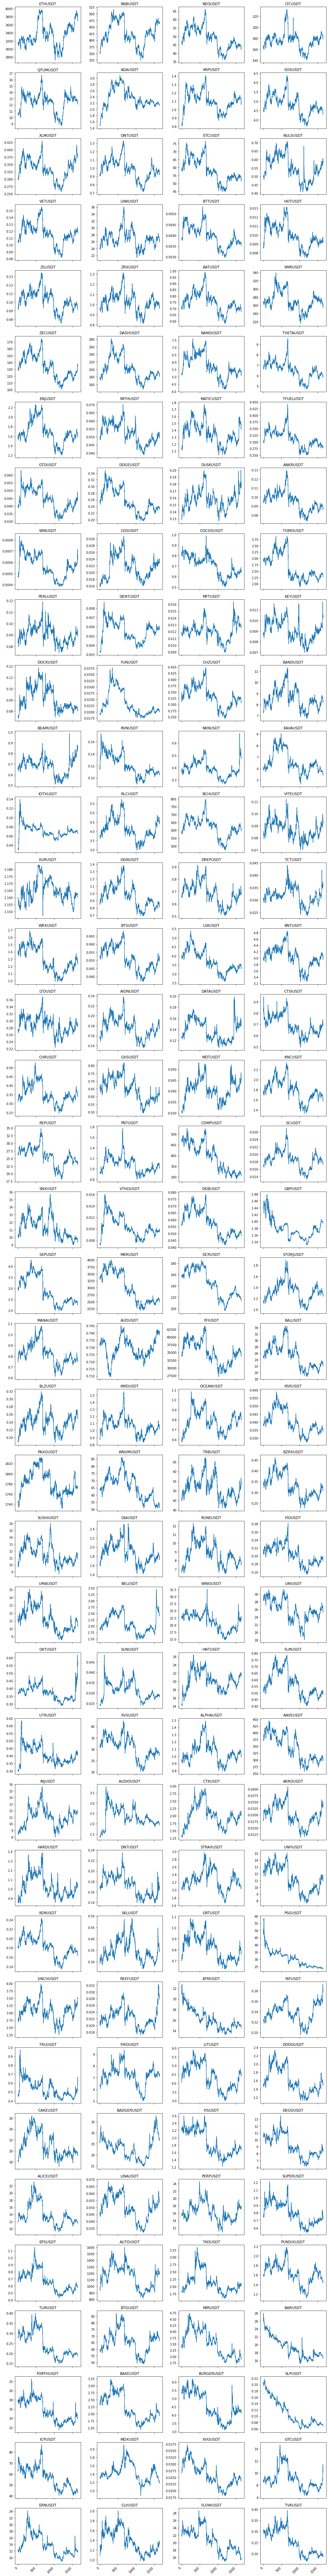

Cluster name: Cluster with BTC


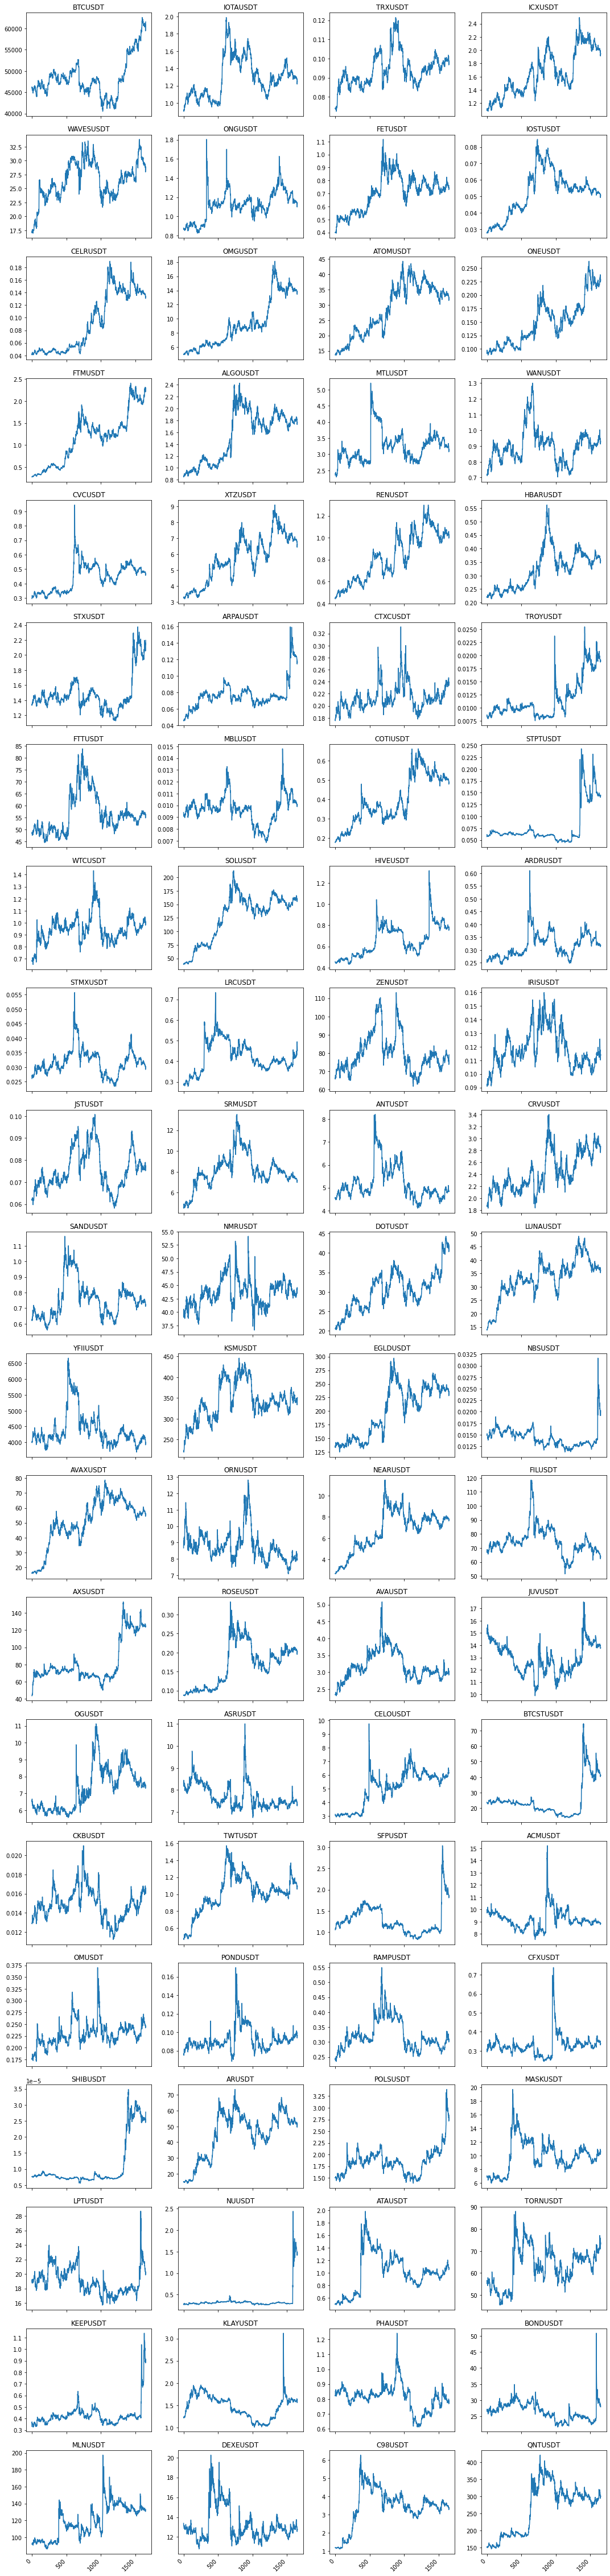

In [10]:
coins_scaled_flatten, symbols, clasters_TSKMeans = clustering(coins, symbols, clustering_method='tskmeans_euclidean')